In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-10 05:58:00.864198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 05:58:01.620859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/eng_hiphop_text.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

266164


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
print(len(corpus))
print(corpus[:10])

258572
['<start> why you always in a mood <end>', '<start> fuckin round actin brand new <end>', '<start> i ain t tryna tell you what to do <end>', '<start> but try to play it cool <end>', '<start> baby i ain t playing by your rules <end>', '<start> everything look better with a view <end>', '<start> why you always in a mood <end>', '<start> fuckin round actin brand new <end>', '<start> i ain t tryna tell you what to do <end>', '<start> but try to play it cool <end>']


In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 25000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)
    
    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7fedafbc1b10> 
 [[  2 119   6 ...   0   0   0]
 [  2 208 258 ...   0   0   0]
 [  2   4  41 ...   0   0   0]
 ...
 [  2   6  95 ...   0   0   0]
 [  2   8  16 ...   0   0   0]
 [  2   8  16 ...   0   0   0]]


In [7]:
tensor.shape

(258572, 31)

In [8]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : the
6 : you
7 : a
8 : it
9 : my
10 : t
11 : me
12 : to
13 : and
14 : m
15 : that
16 : s
17 : in
18 : on
19 : yeah
20 : like


In [9]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (258572, 31)
소스문장 길이:  30
타겟문장 길이:  30


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (206857, 30)
Target Train 길이:  (206857, 30)
Source Test 길이:  (51715, 30)
Target Test 길이:  (51715, 30)


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-10 05:58:23.359291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 05:58:23.396437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 05:58:23.396599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_BatchDataset element_spec=(TensorSpec(shape=(256, 30), dtype=tf.int32, name=None), TensorSpec(shape=(256, 30), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 30), dtype=tf.int32, name=None), TensorSpec(shape=(256, 30), dtype=tf.int32, name=None))>


L355
2024-04-10 05:58:23.397547: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 05:58:23.397639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 05:58:24.407263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [13]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [14]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 30, 25001), dtype=float32, numpy=
array([[[-2.85186892e-04, -1.02267377e-02,  1.06153889e-02, ...,
          1.34058623e-03,  8.14598519e-03,  3.62549035e-04],
        [ 2.60515511e-03,  1.29100488e-04,  2.26028357e-03, ...,
         -1.25485044e-02, -5.74627705e-03,  3.98094207e-03],
        [ 1.22937970e-02,  1.04256449e-02,  1.03549752e-02, ...,
          5.56674972e-03, -3.07850894e-02,  9.33709182e-03],
        ...,
        [ 4.19095270e-02,  6.98425472e-02,  7.58260349e-03, ...,
          5.89849986e-02,  1.90000162e-01,  7.85313919e-02],
        [ 1.12695163e-02,  7.23898113e-02,  3.04157175e-02, ...,
          2.10600290e-02,  1.08356707e-01,  7.72764385e-02],
        [ 5.01194745e-02,  1.06772281e-01, -5.56866080e-02, ...,
          9.17023942e-02,  1.09740123e-01,  4.30122800e-02]],

       [[-2.85186892e-04, -1.02267377e-02,  1.06153889e-02, ...,
          1.34058623e-03,  8.14598519e-03,  3.62549035e-04],
        [ 4.35841503e-03, -8.98106676e-03, -1

In [15]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,400,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    25,626,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,436,201 (135.18 MB)

 Trainable params: 35,436,201 (135.18 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-04-10 05:58:37.961758: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 05:58:37.961979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 05:58:37.962076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

L355
2024-04-10 05:58:37.962304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 05:58:37.962375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 12702 MB memory:  -> device: 0, name: NVIDIA A16-16Q, pci bus id: 0000:06:00.0, compute capability: 8.6


In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [18]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712728724.721549  402634 service.cc:145] XLA service 0x3459dab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712728724.721583  402634 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-10 05:58:44.768420: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 05:58:45.243068: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712728726.242214  402698 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 1740 bytes spill stores, 2152 bytes spill loads

I0000 00:00:1712728726.676614  402698 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712728727.

808/808 ━━━━━━━━━━━━━━━━━━━━ 278s 333ms/step - loss: 1.7233
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 271s 335ms/step - loss: 1.1682
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 271s 335ms/step - loss: 1.0891
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 271s 336ms/step - loss: 1.0340
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 271s 335ms/step - loss: 0.9833
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 271s 335ms/step - loss: 0.9365
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 271s 335ms/step - loss: 0.8936
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 269s 333ms/step - loss: 0.8594
Epoch 9/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 269s 333ms/step - loss: 0.8317
Epoch 10/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 269s 333ms/step - loss: 0.8057


In [19]:
model.save('rnn_eng_hiphop.keras')
model.save('rnn_eng_hiphop.h5')

In [20]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']
    
    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
        
    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '
        
    return generated

In [21]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m a lifeguard <end> '

In [22]:
generate_text(model, tokenizer, init_sentence = '<start> i', max_len = 50)

'<start> i m a lifeguard <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = '<start> i love')

'<start> i love you i m lit <end> '

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> love')

'<start> love is patient <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> Love is')

'<start> love is patient <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> love you ')

'<start> love you so but if you don t know <end> '

hiphop_larry june - imported couches

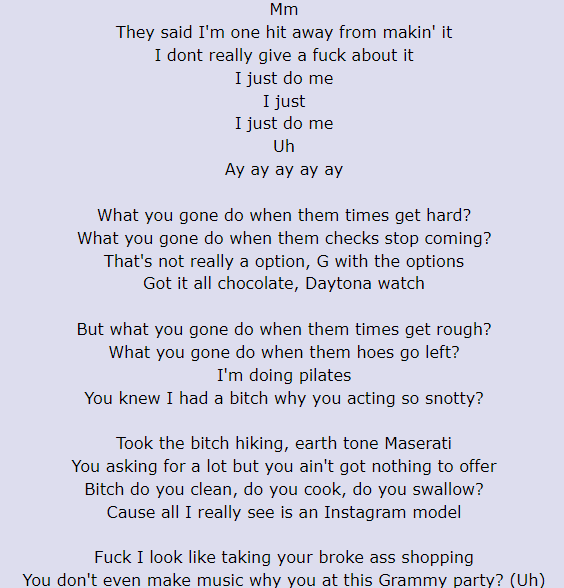

In [27]:
imported_couches = ['they', 'i', 'i just', 'what', 'that', 'got', 'but', 'you', 'took', 'bitch']
for word in imported_couches:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> they know they know they know <end> 
<start> i m a lifeguard <end> 


<start> i just want relief from my stress <end> 
<start> what s the problem <end> 
<start> that s the end of the semis <end> 
<start> got a nigga cravin <end> 
<start> but i m not the one to lie <end> 
<start> you know i m bored <end> 
<start> took a long time yeah <end> 
<start> bitch i m a dog <end> 


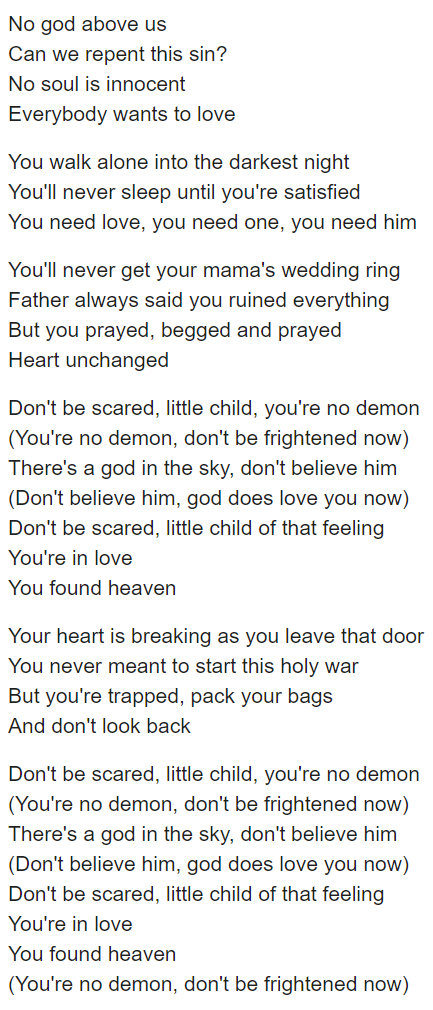

all genre

In [28]:
found_heaven = ['no', 'can', 'everybody', 'you', 'father', 'but', 'heart', 'don', 'there', 'your']
for word in found_heaven:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> no i can t please everybody <end> 
<start> can t nobody tell me nothin <end> 
<start> everybody <end> 


<start> you know i m bored <end> 
<start> father i m not polite <end> 
<start> but i m not the one to lie <end> 
<start> heart is a moment <end> 
<start> don t know what to do <end> 
<start> there s no disrespect <end> 
<start> your bitch <end> 
